Gen 1/200 | Avg: 36.99 | Best: 66.67 | Global Best: 66.67
Gen 2/200 | Avg: 35.28 | Best: 66.67 | Global Best: 66.67
Gen 3/200 | Avg: 30.88 | Best: 66.67 | Global Best: 66.67
Gen 4/200 | Avg: 31.63 | Best: 66.67 | Global Best: 66.67
Gen 5/200 | Avg: 34.25 | Best: 66.67 | Global Best: 66.67
Gen 6/200 | Avg: 29.04 | Best: 52.67 | Global Best: 66.67
Gen 7/200 | Avg: 33.76 | Best: 62.00 | Global Best: 66.67
Gen 8/200 | Avg: 29.43 | Best: 61.33 | Global Best: 66.67
Gen 9/200 | Avg: 31.32 | Best: 54.67 | Global Best: 66.67
Gen 10/200 | Avg: 27.09 | Best: 40.00 | Global Best: 66.67
Gen 11/200 | Avg: 28.19 | Best: 66.67 | Global Best: 66.67
Gen 12/200 | Avg: 26.51 | Best: 65.33 | Global Best: 66.67
Gen 13/200 | Avg: 27.96 | Best: 48.67 | Global Best: 66.67
Gen 14/200 | Avg: 27.08 | Best: 52.00 | Global Best: 66.67
Gen 15/200 | Avg: 26.09 | Best: 66.67 | Global Best: 66.67
Gen 16/200 | Avg: 23.39 | Best: 40.67 | Global Best: 66.67
Gen 17/200 | Avg: 24.85 | Best: 33.33 | Global Best: 66.67
Gen 18

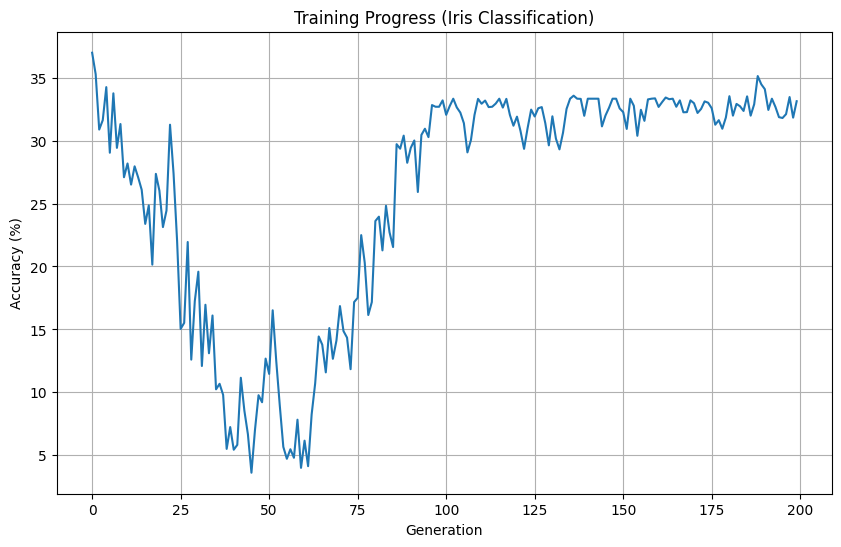

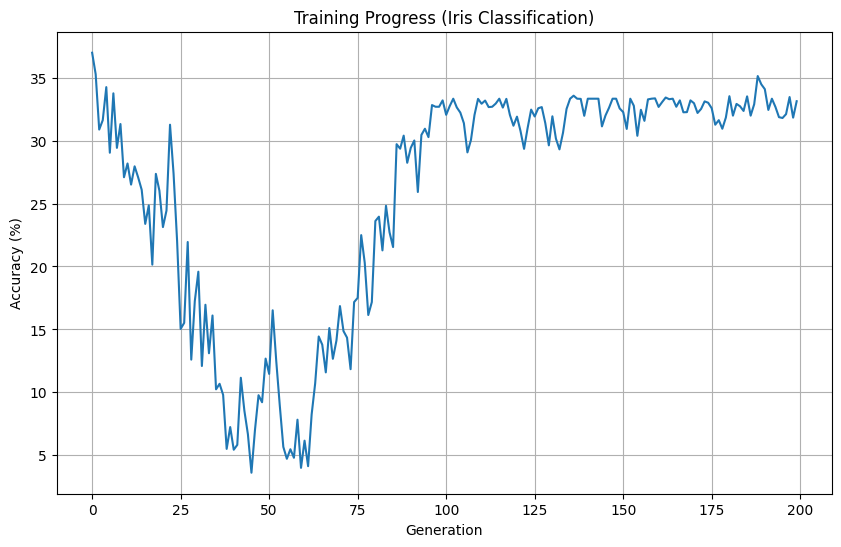

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from copy import deepcopy
import networkx as nx
from matplotlib.lines import Line2D
import imageio
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

# ==================== 网络结构参数（鸢尾花分类） ====================
NETWORK_CONFIG = {
    'INPUT_SIZE': 4,       # 输入层维度(鸢尾花特征)
    'HIDDEN_SIZE': 32,     # 隐藏层神经元数(建议范围:16-64)
    'OUTPUT_SIZE': 3,      # 输出层维度(三类)

    # 训练参数
    'POP_SIZE': 50,        # 种群大小
    'GENERATIONS': 200,    # 进化代数
    'EPISODES_PER_NETWORK': 1,  # 每个网络只评估一次（静态数据）

    # 进化参数
    'MUTATION_RATE': 0.3,
    'ELITE_RATIO': 0.2,
    'WEIGHT_MUTATION_STRENGTH': 0.05,
    'BIAS_MUTATION_STRENGTH': 0.05,
    'OUTPUT_MUTATION_STRENGTH': 0.02
}

# 可视化设置
VISUALIZATION_CONFIG = {
    'SAVE_NETWORK_VIZ': True,    # 是否保存网络可视化
    'VIZ_GENERATIONS': [0, 50, 99]  # 在哪些代进行可视化
}

# ==================== 核心代码 ====================
# 定义激活函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class NeuronGenome:
    def __init__(self, input_size):
        self.weights = np.random.randn(input_size) * 0.1
        self.bias = np.random.randn() * 0.1

    def mutate(self):
        if np.random.rand() < NETWORK_CONFIG['MUTATION_RATE']:
            self.weights += np.random.randn(*self.weights.shape) * NETWORK_CONFIG['WEIGHT_MUTATION_STRENGTH']
            self.bias += np.random.randn() * NETWORK_CONFIG['BIAS_MUTATION_STRENGTH']

    def copy(self):
        copied = NeuronGenome(len(self.weights))
        copied.weights = np.copy(self.weights)
        copied.bias = self.bias
        return copied

class ESPNetwork:
    def __init__(self, hidden_neurons):
        self.hidden_neurons = hidden_neurons
        self.output_weights = np.random.randn(
            len(hidden_neurons),
            NETWORK_CONFIG['OUTPUT_SIZE']
        ) * 0.1

    def forward(self, x):
        h = np.array([np.dot(n.weights, x) + n.bias for n in self.hidden_neurons])
        h = relu(h)
        return softmax(np.dot(h, self.output_weights))

def load_iris_data():
    """加载鸢尾花数据集"""
    data_path = "datasets/iris_dataset.csv"

    if not os.path.exists(data_path):
        print("⚠️ 数据文件不存在，正在生成模拟数据...")
        generate_mock_data()

    df = pd.read_csv(data_path)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

def generate_mock_data():
    """生成模拟鸢尾花数据（用于测试）"""
    from sklearn.datasets import load_iris
    iris = load_iris()
    X, y = iris.data, iris.target
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]),
                      columns=["sepal_length", "sepal_width", "petal_length", "petal_width", "label"])
    df.to_csv("datasets/iris_dataset.csv", index=False)

def evaluate(network):
    """
    评估网络在鸢尾花分类任务上的准确率
    :param network: ESPNetwork 实例
    :return: 准确率（百分比）
    """
    X, y_true = load_iris_data()
    correct = 0

    for i in range(len(X)):
        obs = X[i]
        action_probs = network.forward(obs)
        predicted_class = np.argmax(action_probs)

        if predicted_class == y_true[i]:
            correct += 1

    accuracy = correct / len(X)
    return accuracy * 100  # 返回百分比形式作为适应度值

def run_evolution():
    """主训练函数"""
    # 初始化种群
    subpops = [
        [NeuronGenome(NETWORK_CONFIG['INPUT_SIZE'])
        for _ in range(NETWORK_CONFIG['POP_SIZE'])
    ] for _ in range(NETWORK_CONFIG['HIDDEN_SIZE'])]

    output_weight_pool = [
        np.random.randn(NETWORK_CONFIG['HIDDEN_SIZE'], NETWORK_CONFIG['OUTPUT_SIZE']) * 0.1
        for _ in range(NETWORK_CONFIG['POP_SIZE'])
    ]

    best_scores = []
    best_network = None
    global_best_score = -np.inf

    # 创建输出目录
    os.makedirs("results/network_viz", exist_ok=True)

    for gen in range(NETWORK_CONFIG['GENERATIONS']):
        # 评估种群
        fitnesses = []
        networks = []

        for _ in range(NETWORK_CONFIG['POP_SIZE']):
            # 从每个子种群随机选择神经元
            hidden_indices = [random.randint(0, NETWORK_CONFIG['POP_SIZE']-1)
                            for _ in range(NETWORK_CONFIG['HIDDEN_SIZE'])]
            hidden_neurons = [subpops[i][idx] for i, idx in enumerate(hidden_indices)]

            # 创建网络并评估
            network = ESPNetwork(hidden_neurons)
            network.output_weights = output_weight_pool[random.randint(0, NETWORK_CONFIG['POP_SIZE']-1)]
            reward = evaluate(network)

            fitnesses.append(reward)
            networks.append((network, hidden_indices))

            # 更新全局最佳
            if reward > global_best_score:
                global_best_score = reward
                best_network = deepcopy(network)

        # 进化过程
        elite_count = int(NETWORK_CONFIG['POP_SIZE'] * NETWORK_CONFIG['ELITE_RATIO'])

        # 更新隐藏神经元
        for i in range(NETWORK_CONFIG['HIDDEN_SIZE']):
            # 按适应度排序
            indices = list(range(NETWORK_CONFIG['POP_SIZE']))
            random.shuffle(indices)  # 添加随机性

            # 选择精英
            elites = sorted(zip(fitnesses, subpops[i]),
                          key=lambda x: x[0],
                          reverse=True)[:elite_count]
            elites = [ind.copy() for (_, ind) in elites]

            # 生成新一代
            new_pop = elites[:]
            while len(new_pop) < NETWORK_CONFIG['POP_SIZE']:
                parent = random.choice(elites)
                offspring = parent.copy()
                offspring.mutate()
                new_pop.append(offspring)

            subpops[i] = new_pop

        # 更新输出权重
        elite_indices = np.argsort(fitnesses)[-elite_count:]
        elite_outputs = [output_weight_pool[i] for i in elite_indices]

        new_outputs = [w.copy() for w in elite_outputs]
        while len(new_outputs) < NETWORK_CONFIG['POP_SIZE']:
            base = random.choice(elite_outputs)
            mutated = base + np.random.randn(*base.shape) * NETWORK_CONFIG['OUTPUT_MUTATION_STRENGTH']
            new_outputs.append(mutated)

        output_weight_pool = new_outputs

        # 记录结果
        avg_score = np.mean(fitnesses)
        best_scores.append(avg_score)

        print(f"Gen {gen+1}/{NETWORK_CONFIG['GENERATIONS']} | "
              f"Avg: {avg_score:.2f} | Best: {max(fitnesses):.2f} | "
              f"Global Best: {global_best_score:.2f}")

        # 可视化
        if VISUALIZATION_CONFIG['SAVE_NETWORK_VIZ'] and gen in VISUALIZATION_CONFIG['VIZ_GENERATIONS']:
            visualize_network(
                [subpops[i][0] for i in range(NETWORK_CONFIG['HIDDEN_SIZE'])],  # 取每个子种群第一个个体
                output_weight_pool[0],  # 取第一个输出权重
                gen+1,
                filename=f"results/network_viz/gen_{gen+1}.png"
            )

        # 保存模型和结果
    with open("results/esp_model.pkl", "wb") as f:
        pickle.dump({
            'subpops': subpops,
            'output_weights': output_weights,
            'scores': best_scores,
            'config': NETWORK_CONFIG
        }, f)

    # 绘制训练曲线
    plot_results(best_scores)

    # 返回关键数据供主程序使用
    return subpops, output_weights, best_scores

def visualize_network(hidden_neurons, output_weights, generation, filename=None):
    """可视化网络结构"""
    plt.figure(figsize=(15, 10))
    G = nx.DiGraph()

    # 输入层
    input_nodes = [f"I{i}" for i in range(NETWORK_CONFIG['INPUT_SIZE'])]
    hidden_nodes = [f"H{i}" for i in range(NETWORK_CONFIG['HIDDEN_SIZE'])]
    output_nodes = [f"O{i}" for i in range(NETWORK_CONFIG['OUTPUT_SIZE'])]

    # 添加节点
    for node in input_nodes + hidden_nodes + output_nodes:
        G.add_node(node)

    # 添加输入到隐藏的连接
    for i, neuron in enumerate(hidden_neurons):
        for j in range(NETWORK_CONFIG['INPUT_SIZE']):
            weight = abs(neuron.weights[j])
            color = 'red' if weight > 0 else 'blue'
            G.add_edge(f"I{j}", f"H{i}", weight=weight, color=color)

    # 添加隐藏到输出的连接
    for i in range(NETWORK_CONFIG['HIDDEN_SIZE']):
        for j in range(NETWORK_CONFIG['OUTPUT_SIZE']):
            weight = abs(output_weights[i, j])
            color = 'red' if weight > 0 else 'blue'
            G.add_edge(f"H{i}", f"O{j}", weight=weight, color=color)

    pos = {}
    for i, node in enumerate(input_nodes):
        pos[node] = (0, i)
    for i, node in enumerate(hidden_nodes):
        pos[node] = (1, i)
    for i, node in enumerate(output_nodes):
        pos[node] = (2, i)

    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]
    widths = [G[u][v]['weight'] * 10 for u, v in edges]

    nx.draw(G, pos, with_labels=True, node_size=300, font_size=10,
            edge_color=colors, width=widths, alpha=0.8, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10)

    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Positive Weight'),
        Line2D([0], [0], color='blue', lw=2, label='Negative Weight')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.close()

def plot_results(scores):
    """绘制训练曲线"""
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.xlabel("Generation")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Progress (Iris Classification)")
    plt.grid(True)
    plt.savefig("results/training_curve.png", bbox_inches='tight')
    plt.show()

# ==================== 主程序 ====================
if __name__ == '__main__':
    # 创建目录
    os.makedirs("datasets", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # 运行进化算法
    subpops, output_weights, scores = run_evolution()

    # 保存模型和结果
    with open("results/esp_model.pkl", "wb") as f:
        pickle.dump({
            'subpops': subpops,
            'output_weights': output_weights,
            'scores': scores,
            'config': NETWORK_CONFIG
        }, f)

    # 绘制训练曲线
    plot_results(scores)